# Movie Revenue and Profit Prediction 

This notebook works through regression, classification, and clustering models related to predicting the revenue or profit of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and pre-processed in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  These notebooks are for the modeling stage of the project.

In [9]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport

from sklearn.tree import export_graphviz
import pydot

%matplotlib notebook

In [2]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

movies = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')


# Regression Models

This section will look at whether we can predict the actual revenue of movies using regression modeling techniques.  

In [3]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)]

#Put zero where null
test['Revenue_Actor_Real']=test['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=test['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=test['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)

#Could experiment with logged values of revenue and budget
test['Revenue_Real_Log']=np.log(test['Revenue_Real'])
test['Budget_Real_Log']=np.log(test['Budget_Real'])
test['Revenue_Actor_Real_Log']=np.log(test['Revenue_Actor_Real'])
test['Revenue_Director_Real_Log']=np.log(test['Revenue_Director_Real'])
test['Revenue_Writer_Real_Log']=np.log(test['Revenue_Writer_Real'])

#Create a feature called 'constant' to use in regression model.
test['constant'] =1

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [4]:
model = sm.OLS((test['Revenue_Real']), test[['constant', "Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor']])

#test[['Budget_Real', 'Rating_RT', 'Summer', 'Winter', 'Holiday','Genre_Drama','Genre_Comedy', 
#'Rated_G_PG', 'Rated_R', 'Rated_PG-13','Comp_DreamWorks','Comp_Fox','Comp_Lionsgate','Comp_MGM',
#'Comp_Miramax','Comp_Paramount','Comp_Sony','Comp_Universal','Comp_WarnerBros', 'Comp_Other', 
#'Revenue_Actor_Real','Revenue_Director_Real','Revenue_Writer_Real','isCollection', 'Length']]

In [5]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Revenue_Real   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     240.3
Date:                Sat, 18 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:53:10   Log-Likelihood:                -88305.
No. Observations:                4414   AIC:                         1.767e+05
Df Residuals:                    4372   BIC:                         1.770e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
constant               -6.28

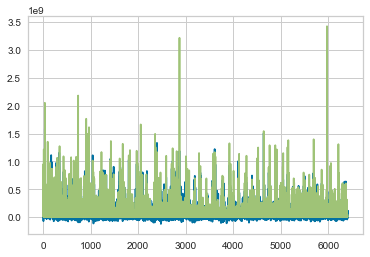

In [6]:
%matplotlib inline
plt.plot(results.fittedvalues)#, test['Revenue_Real'])
plt.plot(test['Revenue_Real'])

### Experiment with logged values of revenue and budget


In [7]:
model = sm.OLS((test['Revenue_Real_Log']), test[['constant', "Budget_Real_Log", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor']])

In [8]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     209.8
Date:                Sat, 18 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:53:20   Log-Likelihood:                -8596.5
No. Observations:                4414   AIC:                         1.727e+04
Df Residuals:                    4375   BIC:                         1.752e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
constant                   0

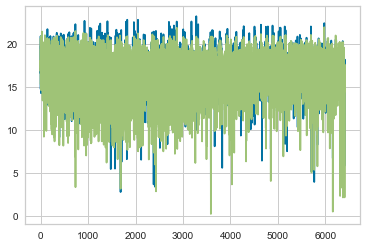

In [10]:
%matplotlib inline
plt.plot(results.fittedvalues)
plt.plot(test['Revenue_Real_Log'])

In [12]:
X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
y = test["Revenue_Real"]
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

#model = Lasso()
model = RidgeCV()
results=model.fit(X, y)
#print(list(zip(features, model.coef_.tolist())))
model.score(X, y)  #0.646

#model = Ridge()
#model.fit(X_train, y_train)
#expected  = y_test
#predicted = model.predict(X_test)
#print(f1_score(expected, predicted, average=None))

#oz = ClassificationReport(model, support=True)
#oz.fit(X_train, y_train)
#oz.score(X_test, y_test)
#oz.poof()

-1035752941117.4078

In [13]:

X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
y = test["Revenue_Real"]

rf = LinearRegression() 
rf.fit(X, y)
rf.score(X, y)


0.6926544413909501

# Classification Models

We can also try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

In addition, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

The lines of code to run these models were from some labs we did in Dr. Bari's class and Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0, and set the train and test sets that we will use for all the classification model testing. 

In [4]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)]

#Make binary variable for if movie made at least 2x budget
test['Profit_Bucket_Binary']=np.where(test['Profit_Bucket']=='<1x', 0, np.where(test['Profit_Bucket']=='[1-2x)', 
                        0, np.where(test['Profit_Bucket']=='[2-3x)', 1, np.where(test['Profit_Bucket']=='[3-4x)', 
                        1, np.where(test['Profit_Bucket']=='[4-5x)', 1, np.where(test['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
test['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


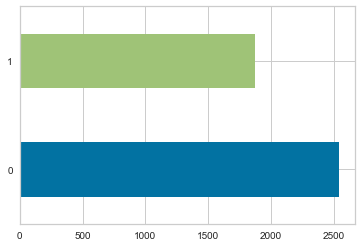

In [5]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket_Binary'].value_counts())
test['Profit_Bucket_Binary'].value_counts().plot(kind='barh')

In [6]:
#Set X, y
X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
y = test["Profit_Bucket_Binary"]

# Next split up the data with the 'train test split' method in the Cross Validation module
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

In [7]:
classifiers = [
    RandomForestClassifier(n_estimators=50, oob_score=True),
    #SVC(kernel='linear'),
    #SVC(kernel='rbf'),
    #SVC(kernel='poly', degree=3),
    LogisticRegression(random_state=1),
    XGBClassifier(), 
    BaggingClassifier(), 
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(),
    KNeighborsClassifier()]

RandomForestClassifier [0.78584392 0.64457831]


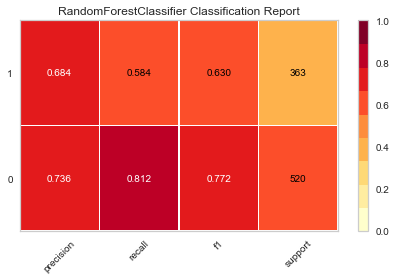

LogisticRegression [0.71319149 0.42978003]


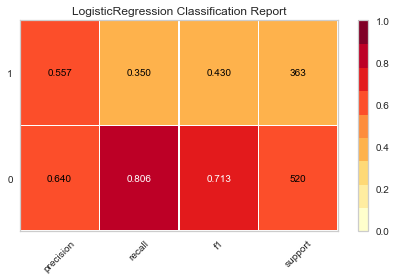

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier [0.8        0.67362146]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


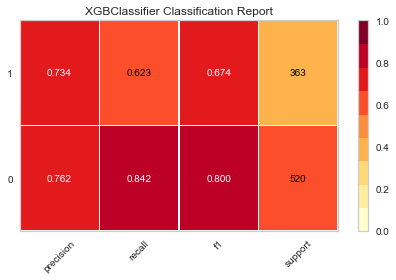

BaggingClassifier [0.76470588 0.59006211]


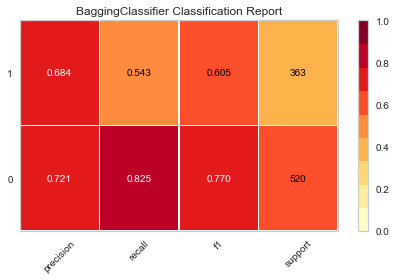

ExtraTreesClassifier [0.7712766  0.59561129]


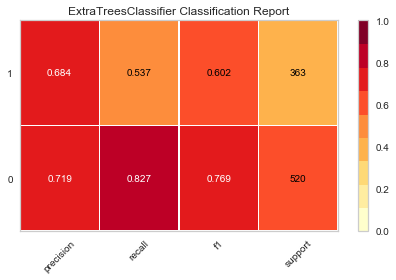

BaggingClassifier [0.77837838 0.625     ]


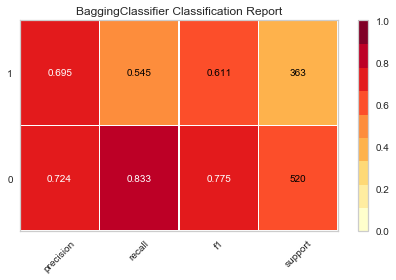

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier [0.34243176 0.44791667]


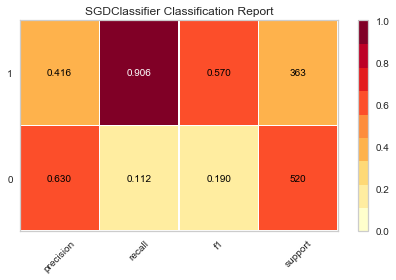

KNeighborsClassifier [0.64689527 0.44541485]


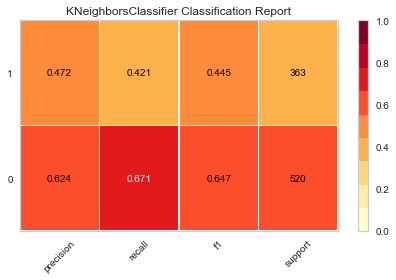

In [8]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    oz.poof()
    

### Random Forests

We will start with Random Forests to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

[0.78363636 0.64264264]


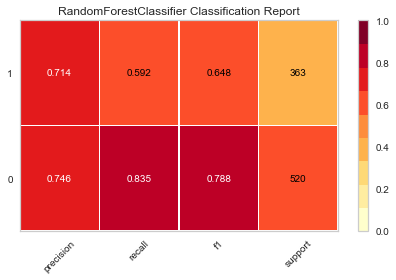

In [72]:
rf = RandomForestClassifier(n_estimators=50, oob_score=True) 
rf.fit(X_train, y_train)
#print(rf.score(X_test, y_test))
expected  = y_test
predicted = rf.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(rf, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [73]:
#Got this code to determine most important feature from here:
#https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Nominated_Minor,0.089279
Budget_Real,0.080053
Rating_IMDB,0.067737
Rating_Metacritic,0.065285
Rating_RT,0.064933
Length,0.063636
Revenue_Actor_Real,0.063151
Won_Minor,0.062561
Revenue_Writer_Real,0.061560
isCollection,0.054991


### Support Vector Classification

We will next use SVC to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.74126871 0.        ]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


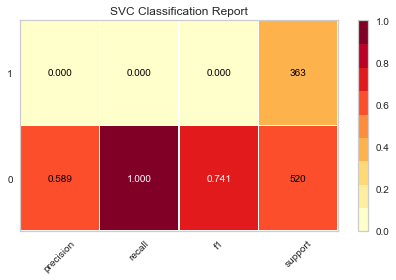

In [38]:
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    if kernel != 'poly':
        model      = SVC(kernel=kernel)
    else:
        model      = SVC(kernel=kernel, degree=3)

model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()
#SVC_report = classification_report(expected, predicted)

### Logistic Regression

We will use Logistic Regression to see how well it predicts "Profit_Bucket_Binary"

[0.71319149 0.42978003]


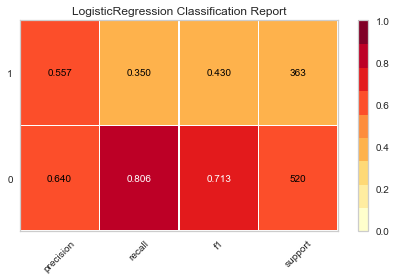

In [37]:
lr = LogisticRegression(random_state=1)
log_reg = lr.fit(X_train, y_train)
#print(log_reg.score(X_test, y_test))
expected  = y_test
predicted = log_reg.predict(X_test)
print(f1_score(expected, predicted, average=None))


oz = ClassificationReport(log_reg, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [33]:
feature_importances = pd.DataFrame(log_reg.coef_.transpose(),
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
feature_importances.abs().sort_values(by='importance', ascending=False)
(feature_importances.head(10))

,importance
Revenue_Director_Real,2.727066e-10
Revenue_Writer_Real,2.514161e-10
Nominated_Minor,9.332844e-15
Won_Minor,5.214332e-15
isCollection,1.408737e-16
Nominated_Major,1.125023e-16
Won_Major,1.068471e-16
Comp_Fox,3.856409e-17
Comp_Disney,2.530992e-17
Comp_Universal,1.579809e-17


### XGBoost

We will use XGBoost to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0.8        0.67362146]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


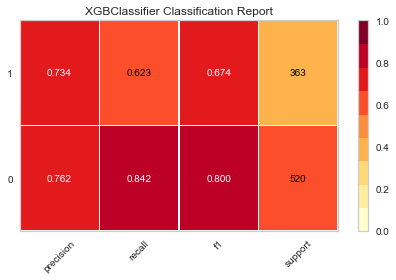

In [47]:
model=XGBClassifier()
model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [48]:
feature_importances = pd.DataFrame(model.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Budget_Real,0.121029
Length,0.083207
Nominated_Minor,0.080182
Rating_IMDB,0.077156
Revenue_Actor_Real,0.068079
Revenue_Writer_Real,0.066566
isCollection,0.052950
Won_Minor,0.045386
Revenue_Director_Real,0.040847
Rating_RT,0.039334


### Bagging Classifier

[0.75651393 0.58499234]


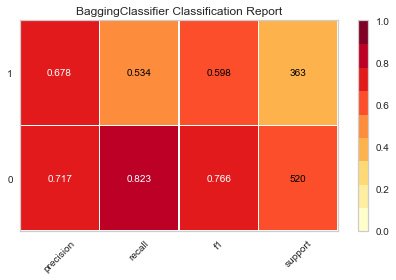

In [49]:
model = BaggingClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### ExtraTreesClassifier

[0.76825969 0.60882801]


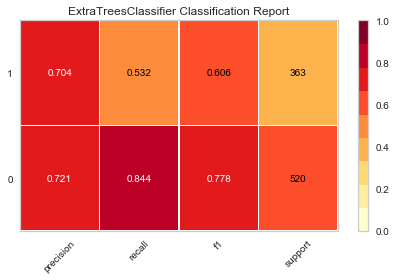

In [50]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### AdaBoostClassifier

[0.77166822 0.64646465]


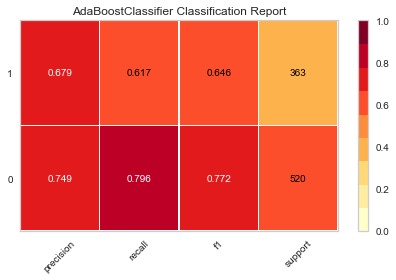

In [51]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()


### SGDClassifier


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[0.17792422 0.56945643]


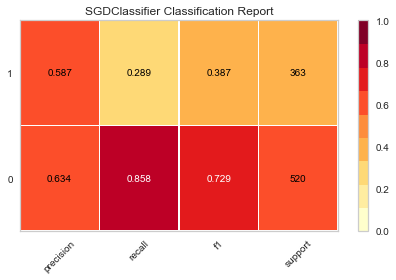

In [52]:
model = SGDClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### K nearest neighbors classifier


[0.64689527 0.44541485]


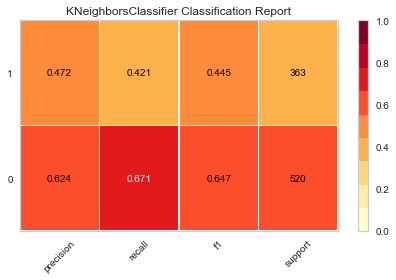

In [53]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

# Classification Models, part 2

Let's run those same models on the original 6 classes we had in the "Profit_Bucket" feature to see which models can classify movies under multiple classes.  

### Create (X, y) train and test sets using "Profit_Bucket" feature

We set the set the train and test sets that we will use for all the classification model testing. 

<1x       1710
[1-2x)     829
[2-3x)     642
>=5x       632
[3-4x)     354
[4-5x)     247
Name: Profit_Bucket, dtype: int64


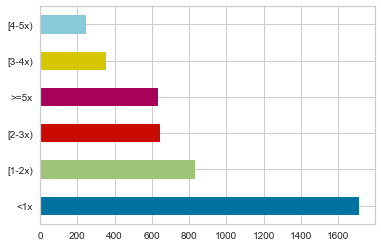

In [54]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket'].value_counts())
test['Profit_Bucket'].value_counts().plot(kind='barh')

In [56]:
#Set X, y
X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
y = test["Profit_Bucket"]

# Next split up the data with the 'train test split' method in the Cross Validation module
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

### Random Forests

We will start with Random Forests to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

[0.68197474 0.44166667 0.26755853 0.2764977  0.025      0.03389831]


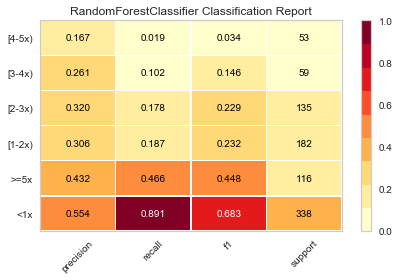

In [57]:
rf = RandomForestClassifier(n_estimators=50, oob_score=True) 
rf.fit(X_train, y_train)
#print(rf.score(X_test, y_test))
expected  = y_test
predicted = rf.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(rf, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [58]:
#Got this code to determine most important feature from here:
#https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Budget_Real,0.090691
Nominated_Minor,0.070060
Revenue_Actor_Real,0.068489
Rating_IMDB,0.066806
Length,0.066731
Rating_RT,0.066524
Revenue_Writer_Real,0.065573
Rating_Metacritic,0.063662
Won_Minor,0.051912
Revenue_Director_Real,0.051731


### Support Vector Classification

We will next use SVC to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.55364455 0.         0.         0.         0.         0.        ]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


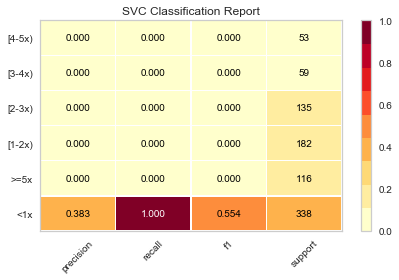

In [59]:
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    if kernel != 'poly':
        model      = SVC(kernel=kernel)
    else:
        model      = SVC(kernel=kernel, degree=3)

model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()
#SVC_report = classification_report(expected, predicted)

### Logistic Regression

We will use Logistic Regression to see how well it predicts "Profit_Bucket_Binary"

[0.56740443 0.09022556 0.21364985 0.07142857 0.02985075 0.02985075]


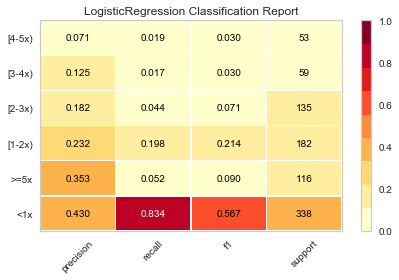

In [60]:
lr = LogisticRegression(random_state=1)
log_reg = lr.fit(X_train, y_train)
#print(log_reg.score(X_test, y_test))
expected  = y_test
predicted = log_reg.predict(X_test)
print(f1_score(expected, predicted, average=None))


oz = ClassificationReport(log_reg, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [63]:
#feature_importances = pd.DataFrame(log_reg.coef_.transpose(),
#   index = X_train.columns,columns=['importance']).sort_values('importance',
#    ascending=False)
#feature_importances.abs().sort_values(by='importance', ascending=False)
#(feature_importances.head(10))

### XGBoost

We will use XGBoost to see how well it predicts both "Profit_Bucket" and "Profit_Bucket_Binary"

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0.67869222 0.47933884 0.27986348 0.23762376 0.07407407 0.13114754]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


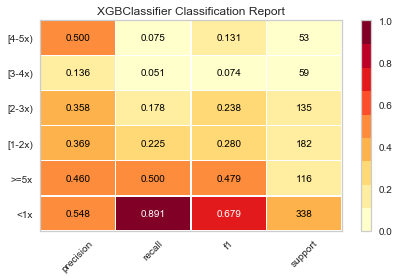

In [64]:
model=XGBClassifier()
model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [65]:
feature_importances = pd.DataFrame(model.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Budget_Real,0.154523
Revenue_Actor_Real,0.077136
Length,0.073116
Revenue_Writer_Real,0.071608
Nominated_Minor,0.065829
Rating_IMDB,0.064070
Revenue_Director_Real,0.058543
Rating_RT,0.057286
Rating_Metacritic,0.054774
Won_Minor,0.052010


### Bagging Classifier

[0.64009662 0.4137931  0.20668693 0.21800948 0.10752688 0.1369863 ]


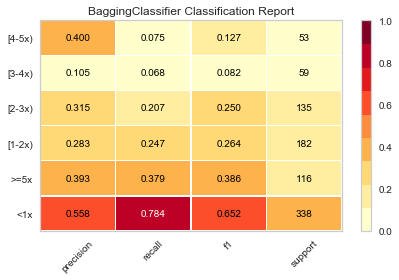

In [66]:
model = BaggingClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### ExtraTreesClassifier

[0.66115702 0.38135593 0.24183007 0.1682243  0.08791209 0.02777778]


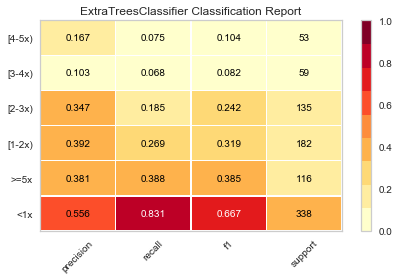

In [67]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### AdaBoostClassifier

[0.69135802 0.42290749 0.2541806  0.20769231 0.12244898 0.11111111]


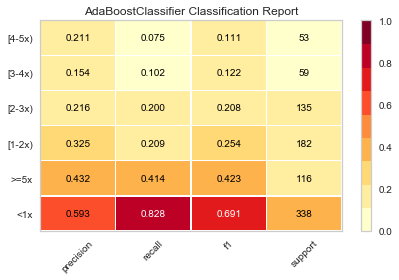

In [68]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()


### SGDClassifier


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.53376906 0.12903226 0.06324111 0.03821656 0.12060302 0.        ]


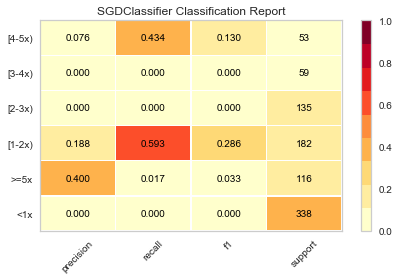

In [69]:
model = SGDClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

### K nearest neighbors classifier


[0.55398037 0.1588785  0.20422535 0.04166667 0.04347826 0.02985075]


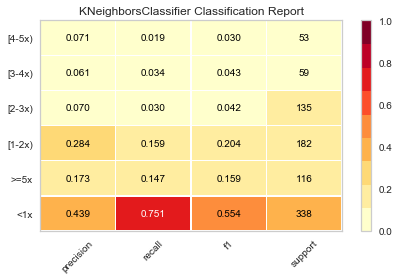

In [70]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
expected  = y_test
predicted = model.predict(X_test)
print(f1_score(expected, predicted, average=None))

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [117]:
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

In [118]:
def model_selection(X, y, estimator):
    """
    Test various estimators.
   """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [60]:
model_selection(X, y, LogisticRegressionCV())

0.7047451669595782

In [61]:
model_selection(X, y, LogisticRegression())

0.9488931402022409

In [86]:
model_selection(X, y, SGDClassifier())

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.752069917203312

In [87]:
model_selection(X, y, KNeighborsClassifier())

0.697254084115398

In [90]:
model_selection(X, y, BaggingClassifier())

0.9690533980582524

In [91]:
model_selection(X, y, ExtraTreesClassifier())

1.0

In [92]:
model_selection(X, y, RandomForestClassifier())

0.9809495010583611

In [102]:


def visual_model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, classes=['0', '1'])
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof() 

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


<IPython.core.display.Javascript object>


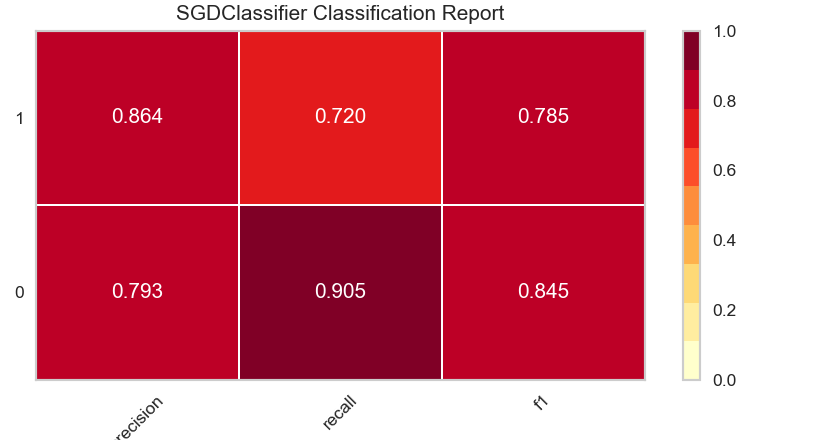

In [103]:
visual_model_selection(X, y, SGDClassifier())

*********************************
Experiment with Ridge, Lasso, ElasticNet....not working yet.
*********************************

In [41]:

#model = Lasso()
model = Lasso(alpha=0.1)
results=model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.09965424812008616

In [42]:

#model = Ridge()
model = Ridge(alpha=0.001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

C:\Users\Rebecca\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.784018604550782e-26 / 1.1102230246251565e-16
  RuntimeWarning)


0.20399609272029495

In [43]:
#model = ElasticNet()
model = ElasticNet(l1_ratio = 0.00001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.1264511206180554